# Preliminaries

In [1]:
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe, kb, Troom
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation9b import SampleModel3Jit
from dissipationtheory.dissipation9b import integrand3jit
from dissipationtheory.dissipation9b import K_jit, Kp
from dissipationtheory.dissipation11e import KmatrixIII_jit, rpIII_jit

In [3]:
from numba import jit

# Reproduce $K_n$ calculation

Reproduce a $K_n$ calculation from `test_dissipationtheory11e.py`.  \
Do this calculation at a frequeny and position where the agrement between the `K_jit` and `KmatrixIII_jit` results is especially bad.

In [4]:
cantilever = CantileverModel(
        f_c = ureg.Quantity(62, 'kHz'),
        k_c = ureg.Quantity(2.8, 'N/m'), 
        V_ts = ureg.Quantity(1, 'V'), 
        R = ureg.Quantity(60, 'nm'),
        angle = ureg.Quantity(20, 'degree'),
        L = ureg.Quantity(1000, 'nm'))

In [5]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 2), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(1, 'nm'))

In [6]:
sample3_jit = SampleModel3Jit(**sample3.args())

In [7]:
loc1_nm = np.array([  0,  0, 20], dtype=np.float64)
loc2_nm = np.array([  0, 10, 20], dtype=np.float64)

loc1_m = 1e-9 * loc1_nm
loc2_m = 1e-9 * loc2_nm

In [8]:
omega = 1e2 * 2 * np.pi

In [9]:
params3_jit = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [10]:
K0a, K1a, K2a = K_jit(**params3_jit)
a = np.array([K0a, K1a, K2a])

In [11]:
j0s = scipy.special.jn_zeros(0, 100.0)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    "omega": omega,
    "omega0": params3_jit['sample'].omega0,
    "kD": params3_jit['sample'].kD,
    "es": params3_jit['sample'].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

In [12]:
K0b, K1b, K2b = KmatrixIII_jit(**args)
b = np.array([K0b[0][0], K1b[0][0], K2b[0][0]])

Compare the results.

In [13]:
def comparetwoK(a,b):
    
    for idx, (Ka, Kb) in enumerate(zip(a,b)):

        err_real = (Ka.real-Kb.real)/Ka.real        
        print('Re[K[{:d}]] {:+0.6e} {:+0.6e}, err = {:+8.4f} %'.format(idx, Ka.real, Kb.real, 100 * err_real))

    print("")
    for idx, (Ka, Kb) in enumerate(zip(a,b)):
        err_imag = (Ka.imag-Kb.imag)/Ka.imag
        print('Im[K[{:d}]] {:+0.6e} {:+0.6e}, err = {:+8.4f} %'.format(idx, Ka.imag, Kb.imag, 100 * err_imag))   

In [14]:
comparetwoK(a,b)

Re[K[0]] +2.221329e-02 +2.221771e-02, err =  -0.0199 %
Re[K[1]] +5.185144e-04 +5.185531e-04, err =  -0.0075 %
Re[K[2]] +2.358781e-05 +2.358776e-05, err =  +0.0002 %

Im[K[0]] +9.785809e-06 +1.501736e-05, err = -53.4606 %
Im[K[1]] +4.313617e-06 +4.290606e-06, err =  +0.5335 %
Im[K[2]] +2.254914e-07 +2.251478e-07, err =  +0.1524 %


# Plot the $K_0$ integrand

Plot the functions contributing to the $K_0$ integrand.

In [15]:
zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

print("x =", x)

y_array = np.logspace(-5, 3, 10000)
r1_array = np.zeros_like(y_array, dtype=np.complex128)
r2_array = np.zeros_like(y_array, dtype=np.complex128)
r3_array = np.zeros_like(y_array, dtype=np.complex128)

for index, y in enumerate(y_array):
    
    args = {
        'y': y,
        'omega': omega, 
        'omega0': params3_jit['sample'].omega0,
        'zr': zjkref,
        'kD': params3_jit['sample'].kD, 
        'es': params3_jit['sample'].epsilon_s}

    r1_array[index] = rpIII_jit(**args)
    r2_array[index] = scipy.special.j0(y * x) * np.exp(-y)
    r3_array[index] = scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y)

x = 0.25


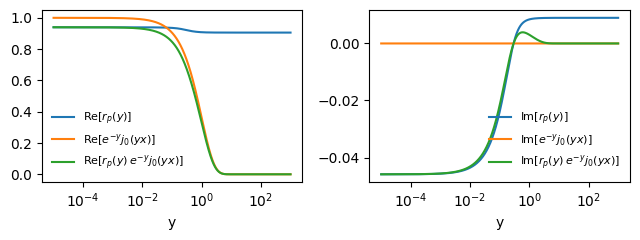

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6.5,2.5))

ax1.semilogx(y_array, np.real(r1_array), '-', label='Re[$r_p(y)$]')
ax1.semilogx(y_array, np.real(r2_array), '-', label='Re[$e^{-y} j_{0}(y x)$]')
ax1.semilogx(y_array, np.real(r3_array), '-', label='Re[$r_p(y) \: e^{-y} j_{0}(y x)$]')
ax1.legend(fontsize=8, frameon=False)
ax1.set_xlabel('y')

ax2.semilogx(y_array, np.imag(r1_array), '-', label='Im[$r_p(y)$]')
ax2.semilogx(y_array, np.imag(r2_array), '-', label='Im[$e^{-y} j_{0}(y x)$]')
ax2.semilogx(y_array, np.imag(r3_array), '-', label='Im[$r_p(y) \: e^{-y} j_{0}(y x)$]')
ax2.legend(fontsize=8, frameon=False)
ax2.set_xlabel('y')

fig.tight_layout()
plt.show()

# Compute the integral using a Riemannian sum

As a reality check, see if we can get the right answer by implementing a brute-force Riemannian sum.

## Logarithmically spaced $y$ axis

I get reasonable agreement, better than 1%, using 1000 *logarithmically* spaced $y$ points. \
Interestingly, the agreement is *uniformly good* for $K_0$, $K_1$, and $K_2$. \
That is, $K_0$, $K_1$, and $K_2$ each have about the same percentage error.

In [17]:
zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

y_array = np.logspace(-5, 3, 1000)
r1_array = np.zeros_like(y_array, dtype=np.complex128)
r2_array = np.zeros_like(y_array, dtype=np.complex128)
r3_array = np.zeros_like(y_array, dtype=np.complex128)

for index, y in enumerate(y_array):
    
    args = {
        'y': y,
        'omega': omega, 
        'omega0': params3_jit['sample'].omega0,
        'zr': zjkref,
        'kD': params3_jit['sample'].kD, 
        'es': params3_jit['sample'].epsilon_s}

    r1_array[index] = scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref
    r2_array[index] = y * scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref**2
    r3_array[index] = y**2 * scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref**3

In [18]:
c1 = np.array([np.sum(r1_array[1:] * np.diff(y_array)),
               np.sum(r2_array[1:] * np.diff(y_array)),
               np.sum(r3_array[1:] * np.diff(y_array))])

In [19]:
comparetwoK(a,c1)

Re[K[0]] +2.221329e-02 +2.200951e-02, err =  +0.9174 %
Re[K[1]] +5.185144e-04 +5.137632e-04, err =  +0.9163 %
Re[K[2]] +2.358781e-05 +2.337167e-05, err =  +0.9163 %

Im[K[0]] +9.785809e-06 +9.707613e-06, err =  +0.7991 %
Im[K[1]] +4.313617e-06 +4.274090e-06, err =  +0.9163 %
Im[K[2]] +2.254914e-07 +2.234252e-07, err =  +0.9163 %


## Linearly spaced $y$ axis

The agreement is poor, especially for Im[$K_0$], if I use *linearly* spaced $y$ points.

In [20]:
%%time

zjkref = loc1_nm[2] + loc2_nm[2]
x = np.sqrt((loc1_nm[0] - loc2_nm[0])**2 + (loc1_nm[1] - loc2_nm[1])**2) / zjkref

y_array = np.linspace(0, 20, 1000)
r1_array = np.zeros_like(y_array, dtype=np.complex128)
r2_array = np.zeros_like(y_array, dtype=np.complex128)
r3_array = np.zeros_like(y_array, dtype=np.complex128)

for index, y in enumerate(y_array):
    
    args = {
        'y': y,
        'omega': omega, 
        'omega0': params3_jit['sample'].omega0,
        'zr': zjkref,
        'kD': params3_jit['sample'].kD, 
        'es': params3_jit['sample'].epsilon_s}

    r1_array[index] = scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref
    r2_array[index] = y * scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref**2
    r3_array[index] = y**2 * scipy.special.j0(y * x) * rpIII_jit(**args) * np.exp(-y) / zjkref**3

CPU times: user 34 ms, sys: 3.05 ms, total: 37 ms
Wall time: 42 ms


In [21]:
c2 = np.array([np.sum(r1_array[1:] * np.diff(y_array)),
               np.sum(r2_array[1:] * np.diff(y_array)),
               np.sum(r3_array[1:] * np.diff(y_array))])

In [22]:
comparetwoK(a,c2)

Re[K[0]] +2.221329e-02 +2.197894e-02, err =  +1.0550 %
Re[K[1]] +5.185144e-04 +5.184948e-04, err =  +0.0038 %
Re[K[2]] +2.358781e-05 +2.358781e-05, err =  -0.0000 %

Im[K[0]] +9.785809e-06 +2.103861e-05, err = -114.9911 %
Im[K[1]] +4.313617e-06 +4.314575e-06, err =  -0.0222 %
Im[K[2]] +2.254914e-07 +2.254914e-07, err =  -0.0000 %


# Recapitulate the `scipy.quad_vec` integration

As a double-check, recapitulate the `scipy.quad_vec` integration.

In [23]:
def func(y, x, omega, omega0, zr, kD, es):
    
    def t1(ell):
        return y**ell
    
    t2 = rpIII_jit(y, omega, omega0, zr, kD, es)
    t3 = scipy.special.j0(y * x) * np.exp(-y)
                 
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

In [24]:
%%time

ans = integrate.quad_vec(func, 
    0., np.inf,
    args=(x,
          omega,
          params3_jit['sample'].omega0,
          zjkref,
          params3_jit['sample'].kD,
          params3_jit['sample'].epsilon_s))[0] @ Kp

ans

CPU times: user 10.4 ms, sys: 689 µs, total: 11.1 ms
Wall time: 10.9 ms


array([2.22132866e-02+9.78580913e-06j, 5.18514425e-04+4.31361676e-06j,
       2.35878082e-05+2.25491372e-07j])

In [25]:
d = np.array([ans[0], ans[1], ans[2]])

Compare to the results returned by `K_jit` (they should be identical).

In [26]:
comparetwoK(a,d)

Re[K[0]] +2.221329e-02 +2.221329e-02, err =  -0.0000 %
Re[K[1]] +5.185144e-04 +5.185144e-04, err =  -0.0000 %
Re[K[2]] +2.358781e-05 +2.358781e-05, err =  -0.0000 %

Im[K[0]] +9.785809e-06 +9.785809e-06, err =  +0.0000 %
Im[K[1]] +4.313617e-06 +4.313617e-06, err =  -0.0000 %
Im[K[2]] +2.254914e-07 +2.254914e-07, err =  -0.0000 %


# A change of variables

Transform the integral using $w = \log(y)$ with $\log$ the natural logarithm. \
See my handwritten notes 2025-09-01.  \
Basically, we are writing the integral as follows:

\begin{equation}
\tilde{K}_{\ell} = \left( \frac{z_{\mathrm{r}}}{z_{k,j}^{\mathrm{ref}}} \right)^{\ell + 1}
 \int_{0}^{\infty} dy \, 
   y^{\ell} 
   e^{-y}
   J_0 (y x) \: 
   r_{p} ( \frac{y}{z_{k,j}^{\mathrm{ref}}}, \omega )
\end{equation}

as

\begin{equation}
\tilde{K}_{\ell} = \left( \frac{z_{\mathrm{r}}}{z_{k,j}^{\mathrm{ref}}} \right)^{\ell + 1}
 \int_{-\infty}^{\infty} dw \, 
   \left( e^{w} \right)^{\ell} e^{w - e^w}
   J_0 (e^{w} x) \: 
   r_{p} ( \frac{e^{w}}{z_{k,j}^{\mathrm{ref}}}, \omega )
\end{equation}

using the transformation $y = e^w$ or, equivalently, $w = \log{y}$.

In [27]:
def gunc(w, x, omega, omega0, zr, kD, es):
    
    def t1(ell):
        return np.exp(w * (ell + 1) - np.exp(w))
    
    t2 = scipy.special.j0(np.exp(w) * x)
    t3 = rpIII_jit(np.exp(w), omega, omega0, zr, kD, es)
    
    return np.array(
        [np.real(t1(0) * t2 * t3) / zr,
         np.imag(t1(0) * t2 * t3) / zr,
         np.real(t1(1) * t2 * t3) / zr**2,
         np.imag(t1(1) * t2 * t3) / zr**2,
         np.real(t1(2) * t2 * t3) / zr**3,
         np.imag(t1(2) * t2 * t3) / zr**3])

What should the lower limit of integration be? \
In my notes handwritten 2025-07-01.03, I recommended $y$ limits of ($10^{-7}$, $20$).  \
In $w$ space, the corresponding limits are

In [28]:
(np.log(1e-7), np.log(20.))

(-16.11809565095832, 2.995732273553991)

Empirically I find that decreasing the lower limit from $w = -16$ to $-20$ in the code below decreases the Im[$K_0$] error from 8 ppm to less than 1 ppm. \
The new lower $w$ limit corresponds to a lower $y$ limit of $2 \times 10^{-9}$.

In [29]:
(np.log(2e-9), np.log(20.))

(-20.030118656386467, 2.995732273553991)

Let us verify that the above integral gives the correct answer when integrated using `integrate.quad_vec` from `scipy`.

In [30]:
%%time

ans = integrate.quad_vec(gunc, 
    -20, 3,
    args=(x,
          omega,
          params3_jit['sample'].omega0,
          zjkref,
          params3_jit['sample'].kD,
          params3_jit['sample'].epsilon_s))[0] @ Kp

ans

CPU times: user 19.1 ms, sys: 607 µs, total: 19.7 ms
Wall time: 20.2 ms


array([2.22132866e-02+9.78581154e-06j, 5.18514427e-04+4.31361678e-06j,
       2.35878091e-05+2.25491382e-07j])

In [31]:
e = np.array([ans[0], ans[1], ans[2]])

In [32]:
comparetwoK(a,e)

Re[K[0]] +2.221329e-02 +2.221329e-02, err =  +0.0000 %
Re[K[1]] +5.185144e-04 +5.185144e-04, err =  -0.0000 %
Re[K[2]] +2.358781e-05 +2.358781e-05, err =  -0.0000 %

Im[K[0]] +9.785809e-06 +9.785812e-06, err =  -0.0000 %
Im[K[1]] +4.313617e-06 +4.313617e-06, err =  -0.0000 %
Im[K[2]] +2.254914e-07 +2.254914e-07, err =  -0.0000 %


We get the expected answer within a margin of error smaller than 1 ppm. \
This finding indicates that we have written the integrand, in transformed form, correctly.

# New integration method

Mimic the function in `KmatrixIII_jit` but now integrate using the transformed variable $w$ instead of $y$. \
Let us divide the $w$ space into subregions of integration using `np.linspace`. \
This corresponds to employing *logarithmic* divisions in $y$ space.


In [33]:
@jit(nopython=True)
def KmatrixIII_jit_new(omega, omega0, kD, es, sj, rk, j0s, an, verbose=False):
    """The unitless response-function matrices for a Type III semiconductor sample."""

    y_min = 2.0e-9
    y_max = 20.0
    N = len(an) - 1
    
    K0 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K1 = np.zeros((len(sj),len(rk)), dtype=np.complex128)
    K2 = np.zeros((len(sj),len(rk)), dtype=np.complex128)

    # Loop over image-charge points
    
    for k, rke in enumerate(rk):    

        # Loop over voltage-test points
        
        for j, sje in enumerate(sj):

            zjkref = sje[2] + rke[2]
            x = np.sqrt((sje[0] - rke[0])**2 + (sje[1] - rke[1])**2) / zjkref

            # Determine breakpoints
            # Adjust number of breakpoint points to increase accuracy; 
            # 6 or more is recommended
            
            BREAKPOINTS = 10
            
            mask = j0s/(x + 1.0e-6) < y_max
            zero_y_locations = j0s[mask] / x
     
            wb = np.hstack(
                (np.linspace(np.log(y_min), np.log(y_max), BREAKPOINTS),
                 np.log(zero_y_locations)))
            wb = np.sort(wb)
            
            
            if verbose:
                
                print('mandatory breakpoints = ', np.linspace(np.log(y_min), np.log(y_max), BREAKPOINTS))
                print('Bessel zero breakpoints = ', np.log(zero_y_locations))
                print('sorted breakpoints = ', wb)
            
            result0 = np.zeros(len(wb)-1, dtype=np.complex128)
            result1 = np.zeros(len(wb)-1, dtype=np.complex128)
            result2 = np.zeros(len(wb)-1, dtype=np.complex128)

            # Loop over subintervals
            
            for index in np.arange(len(wb)-1):
                
                w_vector = np.linspace(wb[index], wb[index+1], N+1)
                dw = (wb[index+1] - wb[index])/N

                integral0 = np.zeros_like(w_vector, dtype=np.complex128)
                integral1 = np.zeros_like(w_vector, dtype=np.complex128)
                integral2 = np.zeros_like(w_vector, dtype=np.complex128)

                # Loop over y-axis points in the subinterval
                
                for m, w in enumerate(w_vector):

                    t0 = np.exp(w)
                    t1 = np.exp(w - t0)
                    t2 = scipy.special.j0(t0 * x)
                    t3 = rpIII_jit(t0, omega, omega0, zjkref, kD, es)
                    
                    integral0[m] = t1 * t2 * t3
                    integral1[m] = t0 * integral0[m]
                    integral2[m] = t0 * integral1[m]                    
                    
                # Sum with Newton-Cotes weights
                
                result0[index] = dw * (an * integral0).sum()  
                result1[index] = dw * (an * integral1).sum()
                result2[index] = dw * (an * integral2).sum()
                
            if verbose:
                print(result0)
                print(result1)
                print(result2)

            K0[j,k] = result0.sum() / zjkref**1
            K1[j,k] = result1.sum() / zjkref**2
            K2[j,k] = result2.sum() / zjkref**3
            
    return K0, K1, K2

Check the accuracy of the new integration method. \
We can see (`verbose=True`) that the breakpoints are indeed equally spaced in $w$ space. \
We can also see that the integrandchanges sign after the Bessel-function zero breakpoint, as expected.

In [34]:
j0s = scipy.special.jn_zeros(0, 100.0)
an, _ = scipy.integrate.newton_cotes(20, 1)

args = {
    "omega": omega,
    "omega0": params3_jit['sample'].omega0,
    "kD": params3_jit['sample'].kD,
    "es": params3_jit['sample'].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an,
    "verbose": True}

K0f, K1f, K2f = KmatrixIII_jit_new(**args)
f = np.array([K0f[0][0], K1f[0][0], K2f[0][0]])

mandatory breakpoints =  [-20.03011866 -17.47169078 -14.91326289 -12.35483501  -9.79640713
  -7.23797925  -4.67955137  -2.12112349   0.43730439   2.99573227]
Bessel zero breakpoints =  [2.26377173]
sorted breakpoints =  [-20.03011866 -17.47169078 -14.91326289 -12.35483501  -9.79640713
  -7.23797925  -4.67955137  -2.12112349   0.43730439   2.26377173
   2.99573227]
[ 2.23933370e-08-1.09365241e-09j  2.89221020e-07-1.41250498e-08j
  3.73542486e-06-1.82429672e-07j  4.82434905e-05-2.35577587e-06j
  6.22859022e-04-3.03603307e-05j  8.00634117e-03-3.81227693e-04j
  9.72342146e-02-3.29192689e-03j  6.11327038e-01+2.41873427e-03j
  1.71295455e-01+1.67883318e-03j -6.73832621e-06-6.68522655e-08j]
[ 3.11614405e-16-1.52187161e-17j  5.19804047e-14-2.53863168e-15j
  8.67083025e-12-4.23462465e-13j  1.44633029e-09-7.06230996e-11j
  2.41151798e-07-1.17489953e-08j  3.99889522e-05-1.89212680e-06j
  6.17641172e-03-1.86609213e-04j  4.05262484e-01+2.98415015e-03j
  4.18220989e-01+4.10691476e-03j -7.70337554e-0

The errors are dramatically improved. \
The error in Im[$K_0$], for example, has gone from $-53.5$ % to $-0.0226$ %, improving by a factor of more than $10^{4}$.

In [35]:
comparetwoK(a,f)

Re[K[0]] +2.221329e-02 +2.221329e-02, err =  +0.0000 %
Re[K[1]] +5.185144e-04 +5.185144e-04, err =  -0.0000 %
Re[K[2]] +2.358781e-05 +2.358781e-05, err =  -0.0000 %

Im[K[0]] +9.785809e-06 +9.785807e-06, err =  +0.0000 %
Im[K[1]] +4.313617e-06 +4.313617e-06, err =  -0.0000 %
Im[K[2]] +2.254914e-07 +2.254914e-07, err =  -0.0000 %


Timing test, comparing the execution time of the old function to that of the new function.

In [36]:
args = {
    "omega": omega,
    "omega0": params3_jit['sample'].omega0,
    "kD": params3_jit['sample'].kD,
    "es": params3_jit['sample'].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an}

In [37]:
%%timeit
KmatrixIII_jit(**args)

22.8 µs ± 447 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [38]:
args = {
    "omega": omega,
    "omega0": params3_jit['sample'].omega0,
    "kD": params3_jit['sample'].kD,
    "es": params3_jit['sample'].epsilon_s,
    "sj": np.array([loc1_nm]),
    "rk": np.array([loc2_nm]),
    "j0s": j0s,
    "an": an,
    "verbose": False}

In [39]:
%%timeit
KmatrixIII_jit_new(**args)

44 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The new integration scheme is approximately 50% slower, with `BREAKPOINTS = 8`. \
This is an acceptable speed, given the dramatic improvement in accuracy.

And, for comparison, we should time `K_jit`, which is what we unit-test against.

In [40]:
params3_jit = {
    'integrand': integrand3jit, 
    'sample': sample3_jit, 
    'omega': omega, 
    'location1': loc1_m, 
    'location2': loc2_m}

In [41]:
%%timeit
K_jit(** params3_jit)

5.25 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Discussion

I have incorporated the above code into `dissipation12e.py` and `test_dissipation12e.py`.  Calling

    python -m unittest -v test_dissipation12e.py --verbose
    
computes $K_0$, $K_1$, and $K_2$ for a representative semi-infinite (Type III) semiconductor sample.
The $K_n$'s are computed at six frequencies $\omega$ logarithmically spaced from $10^{1}$ to $10^{6}$ Hz and, at each frequency, a selection of six distances $\boldsymbol{r}_k$ and $\boldsymbol{s}_j$.  The distances are at small tip-sample separation, with $\boldsymbol{r}_k$ along the $z$ axis such that $r_k^x = 0$, $r_k^y = 0$, and $r_k^z = 20$ or $30$ nm.  At each $\boldsymbol{r}_k$, three $\boldsymbol{s}_j$ values are examined, with $s_j^x = 0$; $s_k^y = 0$, $20$, or $30$ nm; and $s_j^z = 20$ or $30$ nm, following $r_k^z$. 

Ideally, we should unit-test the $K_n$ computations over a range of sample conductivities $\sigma$, charge densities $\rho$, and dielectric constants $\epsilon_{\mathrm{s}}$ as well at various frequencies $\omega$ and distances $\boldsymbol{r}_k$ and $\boldsymbol{s}_j$.  In summary, we have at least six variables to consider.  Allowing six variations for each variable, there are $6^6 = 46,656$ combinations of variables.  Allowing four variations for each variable gives $6^4 = 1296$ combinations.

The unit tests should compare the real and imaginary parts of $K_0$, $K_1$, and $K_2$ computed using `K_jit` and `KmatrixIII_jit`.  Each `K_jit` computation takes approximately 8 ms.  Each `KmatrixIII_jit` computation takes less than $50 \: \mu$s, which is comparatively negligible.  Below I estimate that carrying out $1,296$ and $46,656$ `K_jit` computations takes under 200 ms and 7 minutes, respectively.  Both these times are reasonable.

In [42]:
(np.power(6,4) * 8e-3 / 60, np.power(6,6) * 8e-3 / 60)

(0.1728, 6.2208)

# Unit testing by looping over many parameters

## A better way to loop

We want to loop over all possible combinations of three variables.

In [43]:
r = np.array([1, 2, 3])
s = np.array([4, 5, 6])
t = np.array([7, 8, 9])

How to do this?  Google around and read [here](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python).

In [44]:
import itertools

values = list(itertools.product(r, s, t))

We can see that we get the expected number of tuples, in this case $3^3 = 27$.

In [45]:
len(values)

27

Listing all the tuples, we see that the last list, in this case `t`, is looped over first. \
This makes intuitive sense, and is how I would proceed manually. \
Nice!

In [46]:
values

[(1, 4, 7),
 (1, 4, 8),
 (1, 4, 9),
 (1, 5, 7),
 (1, 5, 8),
 (1, 5, 9),
 (1, 6, 7),
 (1, 6, 8),
 (1, 6, 9),
 (2, 4, 7),
 (2, 4, 8),
 (2, 4, 9),
 (2, 5, 7),
 (2, 5, 8),
 (2, 5, 9),
 (2, 6, 7),
 (2, 6, 8),
 (2, 6, 9),
 (3, 4, 7),
 (3, 4, 8),
 (3, 4, 9),
 (3, 5, 7),
 (3, 5, 8),
 (3, 5, 9),
 (3, 6, 7),
 (3, 6, 8),
 (3, 6, 9)]

Instead of needing nested loops, we can simply loop over the `values` array.

In [47]:
for r, s, t, in values:
    print(r,s,t)

1 4 7
1 4 8
1 4 9
1 5 7
1 5 8
1 5 9
1 6 7
1 6 8
1 6 9
2 4 7
2 4 8
2 4 9
2 5 7
2 5 8
2 5 9
2 6 7
2 6 8
2 6 9
3 4 7
3 4 8
3 4 9
3 5 7
3 5 8
3 5 9
3 6 7
3 6 8
3 6 9


## Looping over distances (small test)

Let's rewrite the code in `test_dissipation12e.py` using this better looping approach. \
Set up the cantilever and sample. \
Do this first, since in this first run we are not going to loop over sample parameters.

In [48]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(60, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm'))

Create arrays of $\omega$, $\boldsymbol{s}_j$, and $\boldsymbol{r}_k$.

In [49]:
sj_nm = np.array(
    [np.array([  0,  0,  20], dtype=np.float64),
     np.array([  0,  0,  30], dtype=np.float64),
     np.array([  0,  0, 150], dtype=np.float64)])

rk_nm = np.array(
    [np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0, 10, 20], dtype=np.float64),
     np.array([  0, 20, 20], dtype=np.float64),
     np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0, 15, 30], dtype=np.float64),
     np.array([  0, 30, 30], dtype=np.float64)])

omegas = 2 * np.pi * np.array(
    [1e1, 1e2, 1e3, 1e4, 1e5, 1e6], dtype=np.float64)

In [50]:
values = list(itertools.product(omegas, sj_nm, rk_nm))
len(values)

108

Precompute Bessel function zeros and integration weights.

In [51]:
j0s = scipy.special.jn_zeros(0, 100.0)
an, _ = scipy.integrate.newton_cotes(20, 1)

Ok.  Ready, set, loop!

In [52]:
%%time

Kn     = np.zeros((len(values),3), dtype=np.complex128)
Kn_jit = np.zeros((len(values),3), dtype=np.complex128)

for index, (omega, sj, rk) in enumerate(values):

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20, -2), ''),  # watch the sign
        sigma = ureg.Quantity(1e-7, 'S/m'),
        rho = ureg.Quantity(1e21, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())    
    
    params_a = {
        'integrand': integrand3jit,
        'sample': sample3_jit,
        'omega': omega,
        'location1': 1.0e-9 * sj,
        'location2': 1.0e-9 * rk
    }
    
    K0a, K1a, K2a = K_jit(**params_a)
    Kn[index] = np.array([K0a, K1a, K2a])
    
    params_b = {
        "omega": omega,
        "omega0": params_a['sample'].omega0,
        "kD": params_a['sample'].kD,
        "es": params_a['sample'].epsilon_s,
        "sj": np.array([sj]),
        "rk": np.array([rk]),
        "j0s": j0s,
        "an": an,
        "verbose": False}

    K0b, K1b, K2b = KmatrixIII_jit_new(**params_b)
    Kn_jit[index] = np.array([K0b[0][0], K1b[0][0], K2b[0][0]])
    

CPU times: user 626 ms, sys: 65.8 ms, total: 692 ms
Wall time: 534 ms


For display purposes, create a pandas dataframe.

In [53]:
df = pd.DataFrame(
    values, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]'])

for index in [0, 1, 2]:
    
    df['Re[$K_{:1d}'.format(index) + '^{a}$]'] = np.real(Kn[:,index])
    df['Re[$K_{:1d}'.format(index) + '^{b}$]'] = np.real(Kn_jit[:,index])

    df['Im[$K_{:1d}'.format(index) + '^{a}$]'] = np.imag(Kn[:,index])
    df['Im[$K_{:1d}'.format(index) + '^{b}$]'] = np.imag(Kn_jit[:,index])

In [54]:
pd.options.display.float_format = '{:,.2e}'.format
df

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],Re[$K_0^{a}$],Re[$K_0^{b}$],Im[$K_0^{a}$],Im[$K_0^{b}$],Re[$K_1^{a}$],Re[$K_1^{b}$],Im[$K_1^{a}$],Im[$K_1^{b}$],Re[$K_2^{a}$],Re[$K_2^{b}$],Im[$K_2^{a}$],Im[$K_2^{b}$]
0,6.28e+01,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",2.30e-02,2.30e-02,-1.99e-04,-1.99e-04,5.68e-04,5.68e-04,-5.35e-06,-5.35e-06,2.83e-05,2.83e-05,-2.76e-07,-2.76e-07
1,6.28e+01,"[0.0, 0.0, 20.0]","[0.0, 10.0, 20.0]",2.24e-02,2.24e-02,-1.93e-04,-1.93e-04,5.19e-04,5.19e-04,-4.87e-06,-4.87e-06,2.36e-05,2.36e-05,-2.29e-07,-2.29e-07
2,6.28e+01,"[0.0, 0.0, 20.0]","[0.0, 20.0, 20.0]",2.06e-02,2.06e-02,-1.76e-04,-1.76e-04,4.07e-04,4.07e-04,-3.77e-06,-3.77e-06,1.42e-05,1.42e-05,-1.36e-07,-1.36e-07
3,6.28e+01,"[0.0, 0.0, 20.0]","[0.0, 0.0, 30.0]",1.85e-02,1.85e-02,-1.57e-04,-1.57e-04,3.64e-04,3.64e-04,-3.37e-06,-3.37e-06,1.45e-05,1.45e-05,-1.40e-07,-1.40e-07
4,6.28e+01,"[0.0, 0.0, 20.0]","[0.0, 15.0, 30.0]",1.77e-02,1.77e-02,-1.50e-04,-1.50e-04,3.20e-04,3.20e-04,-2.94e-06,-2.94e-06,1.12e-05,1.12e-05,-1.07e-07,-1.07e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,6.28e+06,"[0.0, 0.0, 150.0]","[0.0, 10.0, 20.0]",5.32e-03,5.32e-03,-5.28e-05,-5.28e-05,3.12e-05,3.12e-05,-3.10e-07,-3.10e-07,3.65e-07,3.65e-07,-3.62e-09,-3.62e-09
104,6.28e+06,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",5.29e-03,5.29e-03,-5.26e-05,-5.26e-05,3.07e-05,3.07e-05,-3.05e-07,-3.05e-07,3.54e-07,3.54e-07,-3.51e-09,-3.51e-09
105,6.28e+06,"[0.0, 0.0, 150.0]","[0.0, 0.0, 30.0]",5.03e-03,5.03e-03,-5.00e-05,-5.00e-05,2.80e-05,2.80e-05,-2.78e-07,-2.78e-07,3.11e-07,3.11e-07,-3.09e-09,-3.09e-09
106,6.28e+06,"[0.0, 0.0, 150.0]","[0.0, 15.0, 30.0]",5.01e-03,5.01e-03,-4.98e-05,-4.98e-05,2.77e-05,2.77e-05,-2.75e-07,-2.75e-07,3.04e-07,3.04e-07,-3.02e-09,-3.02e-09


Too much information!


What we really want to know about is the errors, so compute error vectors. \
Represent the errors as a complex 3-vector (equivalent to a real 6-vector). \
The real part is the relative error in the real part of $K_n$ and the imaginary part is the relative error in the imaginary part of $K_n$. \
Also compute $\epsilon$, the rms error of 6-vector of errors. 

In [55]:
Kn_errors = np.zeros((len(values),3), dtype=np.complex128)
epsilon = np.zeros((len(values)), dtype=np.float64)
c = np.zeros(3, dtype=np.complex128)

for index1, (a,b) in enumerate(zip(Kn, Kn_jit)):
    
    for index2 in [0, 1, 2]:
    
        c[index2] = complex(1,0) * (a[index2].real - b[index2].real) / a[index2].real \
                  + complex(0,1) * (a[index2].imag - b[index2].imag) / a[index2].imag
            
    Kn_errors[index1] = c
    
    epsilon[index1] = np.sqrt(np.real(np.sum(c * np.conj(c))))


Create a new pandas dataframe.

In [56]:
df = pd.DataFrame(
    values, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]'])

Add the errors.

In [57]:
for index in [0, 1, 2]:
    
    df['$\epsilon$(Re[$K_{:1d}$])'.format(index)] = np.real(Kn_errors[:,index])
    df['$\epsilon$(Im[$K_{:1d}$])'.format(index)] = np.imag(Kn_errors[:,index])
    
df['$\epsilon$'] = epsilon

Display the dataframe elements in exponential format with three digits. \
Sort the dataframe by the total error $\epsilon$, from largest to smallest.

In [58]:
pd.options.display.float_format = '{:,.3e}'.format
df.sort_values(by='$\epsilon$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon$(Re[$K_0$]),$\epsilon$(Im[$K_0$]),$\epsilon$(Re[$K_1$]),$\epsilon$(Im[$K_1$]),$\epsilon$(Re[$K_2$]),$\epsilon$(Im[$K_2$]),$\epsilon$
52,6.283e+03,"[0.0, 0.0, 150.0]","[0.0, 15.0, 30.0]",-6.102e-08,2.660e-06,-1.053e-07,-3.129e-06,4.272e-07,-2.918e-05,2.947e-05
51,6.283e+03,"[0.0, 0.0, 150.0]","[0.0, 0.0, 30.0]",-5.884e-08,2.574e-06,-9.662e-08,-3.441e-06,6.269e-07,-2.876e-05,2.909e-05
50,6.283e+03,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",-1.694e-08,3.679e-06,-2.533e-08,7.966e-06,2.435e-07,-7.024e-06,1.124e-05
49,6.283e+03,"[0.0, 0.0, 150.0]","[0.0, 10.0, 20.0]",-1.483e-08,3.635e-06,-3.213e-08,7.493e-06,4.055e-07,-7.389e-06,1.114e-05
48,6.283e+03,"[0.0, 0.0, 150.0]","[0.0, 0.0, 20.0]",-1.396e-08,3.620e-06,-2.816e-08,7.341e-06,5.191e-07,-7.455e-06,1.108e-05
...,...,...,...,...,...,...,...,...,...,...
82,6.283e+05,"[0.0, 0.0, 30.0]","[0.0, 15.0, 30.0]",2.336e-09,2.339e-09,-3.733e-09,-3.702e-09,-4.580e-08,-4.547e-08,6.484e-08
73,6.283e+05,"[0.0, 0.0, 20.0]","[0.0, 10.0, 20.0]",2.336e-09,2.343e-09,-3.733e-09,-3.636e-09,-4.580e-08,-4.523e-08,6.467e-08
98,6.283e+06,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",2.773e-09,2.773e-09,4.102e-09,4.101e-09,4.512e-08,4.510e-08,6.417e-08
80,6.283e+05,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",2.773e-09,2.773e-09,4.102e-09,4.075e-09,4.512e-08,4.480e-08,6.396e-08


Interestingly, the largest errors at not a the lowest frequency, but at an intermediate frequency. \
The errors are no larger than 0.2%.

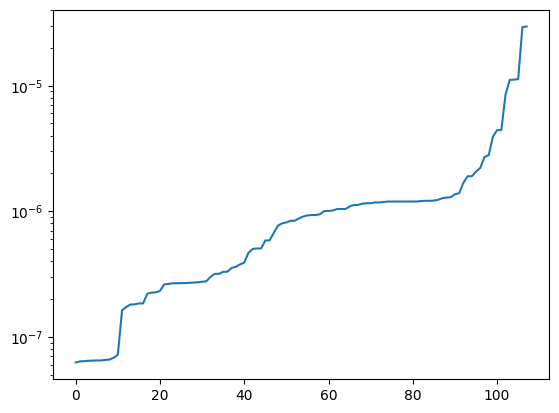

In [59]:
plt.semilogy(sorted(df['$\epsilon$']))
plt.show()

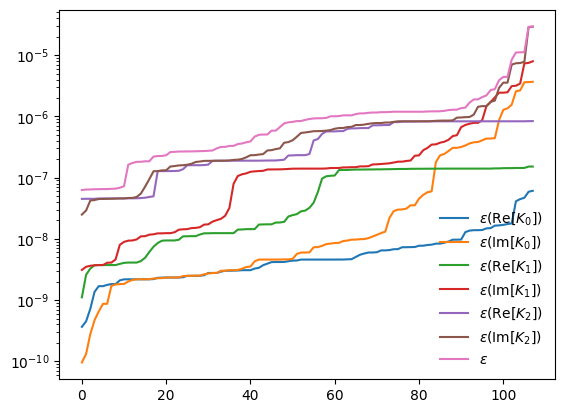

In [60]:
for key in [
       '$\epsilon$(Re[$K_0$])', '$\epsilon$(Im[$K_0$])', 
       '$\epsilon$(Re[$K_1$])', '$\epsilon$(Im[$K_1$])', 
       '$\epsilon$(Re[$K_2$])', '$\epsilon$(Im[$K_2$])', 
       '$\epsilon$']:
    
    plt.semilogy(sorted(abs(df[key])), label=key)

plt.legend(frameon=False)
plt.show()    

## Looping over sample parameters (large test)

Let's think about what range of $\sigma$, $\rho$, and $\epsilon_{\mathrm{s}}$ we want to use. \
Review `Marohn202504--MRS-Spring-Meeting--handout.pdf`.

**Dielectric constant**.  \
For $\epsilon_{\mathrm{s}}$, the real part should vary from 3 (organic semiconductors) to 100 (lead-halide perovskites).  \
Let the imaginary vary from 0 to 10 percent of the real part.

In [61]:
epsilons = np.array([complex(  3, 0), complex(  3,  -0.3),
                     complex( 10, 0), complex( 10,  -1.0),
                     complex( 10, 0), complex( 20,  -2.0),
                     complex(100, 0), complex(100, -10.0)])

**Conductivity**. \
We know $\omega = \sigma / (\epsilon_{\mathrm{s}}^{\prime} \epsilon_0)$ or, equivalently, $\sigma = \omega \, \epsilon_{\mathrm{s}}^{\prime} \epsilon_0$. \
Confirm that the units work.


In [62]:
(ureg.Quantity(1, 'Hz') * epsilon0).to('S/m')

<Quantity(8.8541878128e-12, 'siemens / meter')>

Take the array of $\omega$ and array of $\epsilon_{\mathrm{s}}$ and make a tensor product of associated conductivities $\sigma$. \
What is the smallest and largest conductivity in this list?

In [63]:
sigma = np.array([ureg.Quantity(omega * epsilon * epsilon0, 'S/m').magnitude
                  for omega, epsilon in list(itertools.product(ureg.Quantity(omegas, 'Hz'), epsilons.real))])

In [64]:
(sigma.min(), sigma.max())

(1.6689750831718054e-09, 0.005563250277239352)

Now create a list of conductivities, by hand, that spans this range.

In [65]:
sigmas = np.array([1e-10, 1e-8, 1e-7, 1e-6, 1e-4, 1e-2])  # S/m

**Charge density**.

We know that the BLDS frequency shift at zero frequency depends on a unitless charge density as follows

\begin{equation}
\hat{\rho}_3 = \frac{z_{\mathrm{c}}^2}{7.742 \ \epsilon_{\mathrm{s}}^{\prime} \lambda_{\mathrm{D}}^2}
 = \frac{z_{\mathrm{c}}^2 e^2 \rho}{7.742  \epsilon_{\mathrm{s}}^{\prime}  \epsilon_0 k_{\mathrm{B}} T}.
\end{equation}

Solving for charge density, 

\begin{equation}
\rho = 7.742  \hat{\rho}_3 \frac{\epsilon_{\mathrm{s}}^{\prime}  \epsilon_0 k_{\mathrm{B}} T}
            {z_{\mathrm{c}}^2 e^2}
\end{equation}

Confirm that the units work.

In [66]:
((epsilon0 * kb * Troom)/(ureg.Quantity(10, 'nm')**2 * qe**2)).to('1/m^3')

<Quantity(1.4198616884161066e+22, '1 / meter ** 3')>

Take the array of $\epsilon_{\mathrm{s}}^{\prime}$ and $z_{c}$ and make a tensor of $\rho$ values assuming $\hat{\rho}_3 = 1$ for now.

In [67]:
rho = np.array([7.742 * ureg.Quantity((epsilon * epsilon0 * kb * Troom) / 
                (qe**2 * ureg.Quantity(sjz, 'nm')**2), '1/m^3').magnitude
                  for sjz, epsilon in list(itertools.product(sj_nm.T[2], epsilons.real))])

In [68]:
(rho.min(), rho.max())

(1.4656758922289993e+21, 2.748142297929374e+24)

The BLDS frequency shift at zero frequency changes when $\hat{\rho}_3$ varies from $10^{-2}$ to $10^{2}$. \
This suggests we want $\rho$ to range from $10^{19}$ to $10^{25}$ or $10^{26}$, a six or seven decade range. 

In [69]:
rhos = np.array([1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25])  # 1/m^3

We are now ready to loop! \
Make a master list of numbers to loop over.

In [70]:
values = list(itertools.product(omegas, sj_nm, rk_nm, epsilons, sigmas, rhos))
len(values)

36288

Ready, set, loop!

In [71]:
%%time

Kn     = np.zeros((len(values),3), dtype=np.complex128)
Kn_jit = np.zeros((len(values),3), dtype=np.complex128)

for index, (omega, sj, rk, epsilon, sigma, rho) in enumerate(values):

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(epsilon, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())
    
    params_a = {
        'integrand': integrand3jit,
        'sample': sample3_jit,
        'omega': omega,
        'location1': 1.0e-9 * sj,
        'location2': 1.0e-9 * rk
    }
    
    K0a, K1a, K2a = K_jit(**params_a)
    Kn[index] = np.array([K0a, K1a, K2a])
    
    params_b = {
        "omega": omega,
        "omega0": params_a['sample'].omega0,
        "kD":params_a['sample'].kD,
        "es": params_a['sample'].epsilon_s,
        "sj": np.array([sj]),
        "rk": np.array([rk]),
        "j0s": j0s,
        "an": an,
        "verbose": False}

    K0b, K1b, K2b = KmatrixIII_jit_new(**params_b)
    Kn_jit[index] = np.array([K0b[0][0], K1b[0][0], K2b[0][0]])

CPU times: user 3min 35s, sys: 3.57 s, total: 3min 39s
Wall time: 4min 22s


The above loop takes a few minutes to run. \
Spot check some of the computed $K_{n}$ values.

In [72]:
(Kn[0], Kn_jit[0])

(array([1.25643421e-02-8.50408257e-05j, 3.13036048e-04-2.57792722e-07j,
        1.56336889e-05-1.48488631e-09j]),
 array([1.25643442e-02-8.50415601e-05j, 3.13036009e-04-2.57805343e-07j,
        1.56336758e-05-1.48496199e-09j]))

In [73]:
(Kn[-1], Kn_jit[-1])

(array([5.45468987e-03-4.39294317e-05j, 2.94778805e-05-2.31807381e-07j,
        3.14182088e-07-2.41305590e-09j]),
 array([5.45468986e-03-4.39294316e-05j, 2.94778809e-05-2.31807382e-07j,
        3.14182161e-07-2.41305628e-09j]))

As above, compute the error vectors.

In [74]:
Kn_errors = np.zeros((len(values),3), dtype=np.complex128)
epsilon = np.zeros((len(values)), dtype=np.float64)
c = np.zeros(3, dtype=np.complex128)

for index1, (a,b) in enumerate(zip(Kn, Kn_jit)):
    
    for index2 in [0, 1, 2]:
    
        c[index2] = complex(1,0) * (a[index2].real - b[index2].real) / a[index2].real \
                  + complex(0,1) * (a[index2].imag - b[index2].imag) / a[index2].imag
            
    Kn_errors[index1] = c
    
    epsilon[index1] = np.sqrt(np.real(np.sum(c * np.conj(c))))

Create a new pandas dataframe and add the errors.

In [75]:
dg = pd.DataFrame(
    values, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]', 
             '$\epsilon_{\mathrm{r}}$', '$\sigma$ [S/m]', '$\rho$ [1/m$^3$]'])

for index in [0, 1, 2]:
    
    dg['$\epsilon$(Re[$K_{:1d}$])'.format(index)] = np.real(Kn_errors[:,index])
    dg['$\epsilon$(Im[$K_{:1d}$])'.format(index)] = np.imag(Kn_errors[:,index])
    
dg['$\epsilon$'] = epsilon

Ok, display the results, sorted by error.

In [76]:
pd.options.display.float_format = '{:,.1e}'.format
dg.sort_values(by='$\epsilon$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon_{\mathrm{r}}$,$\sigma$ [S/m],$\rho$ [1/m$^3$],$\epsilon$(Re[$K_0$]),$\epsilon$(Im[$K_0$]),$\epsilon$(Re[$K_1$]),$\epsilon$(Im[$K_1$]),$\epsilon$(Re[$K_2$]),$\epsilon$(Im[$K_2$]),$\epsilon$
28161,6.3e+05,"[0.0, 0.0, 30.0]","[0.0, 30.0, 30.0]",1.0e+02+0.0e+00j,1.0e-06,1.0e+19,1.3e-09,-6.3e-05,-1.3e-08,-2.5e-04,-1.9e-07,-2.5e-04,3.6e-04
16051,6.3e+03,"[0.0, 0.0, 30.0]","[0.0, 30.0, 30.0]",1.0e+02+0.0e+00j,1.0e-08,1.0e+19,1.3e-09,-6.3e-05,-1.3e-08,-2.5e-04,-1.9e-07,-2.5e-04,3.6e-04
22106,6.3e+04,"[0.0, 0.0, 30.0]","[0.0, 30.0, 30.0]",1.0e+02+0.0e+00j,1.0e-07,1.0e+19,1.3e-09,-6.3e-05,-1.3e-08,-2.5e-04,-1.9e-07,-2.5e-04,3.6e-04
3948,6.3e+01,"[0.0, 0.0, 30.0]","[0.0, 30.0, 30.0]",1.0e+02+0.0e+00j,1.0e-10,1.0e+19,1.3e-09,-6.3e-05,-1.3e-08,-2.5e-04,-1.9e-07,-2.5e-04,3.6e-04
27825,6.3e+05,"[0.0, 0.0, 30.0]","[0.0, 15.0, 30.0]",1.0e+02+0.0e+00j,1.0e-06,1.0e+19,1.5e-09,-6.4e-05,-3.8e-09,-2.5e-04,-4.6e-08,-2.4e-04,3.6e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14823,6.3e+03,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-02,1.0e+23,2.9e-09,3.2e-09,2.6e-09,4.5e-10,2.9e-08,9.5e-10,2.9e-08
8768,6.3e+02,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-04,1.0e+23,2.9e-09,3.2e-09,2.6e-09,4.5e-10,2.9e-08,9.5e-10,2.9e-08
20871,6.3e+04,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-02,1.0e+23,2.9e-09,3.2e-09,2.6e-09,4.5e-10,2.9e-08,9.5e-10,2.9e-08
2727,6.3e+01,"[0.0, 0.0, 30.0]","[0.0, 20.0, 20.0]",3.0e+00+0.0e+00j,1.0e-02,1.0e+23,2.9e-09,3.2e-09,2.6e-09,4.5e-10,2.9e-08,9.5e-10,2.9e-08


Ok, the errors are no larger than 1.2%.

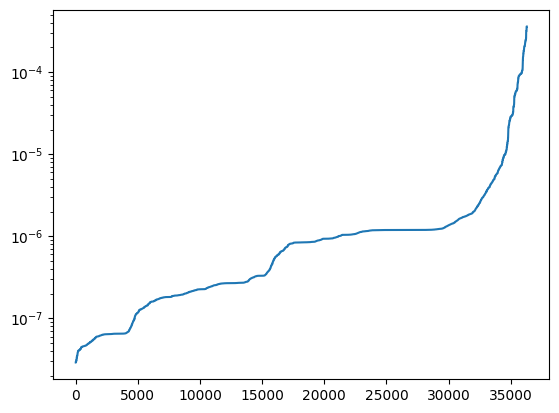

In [77]:
plt.semilogy(sorted(dg['$\epsilon$']))
plt.show()

In [78]:
dg.keys()

Index(['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]', '$\epsilon_{\mathrm{r}}$',
       '$\sigma$ [S/m]', '$\rho$ [1/m$^3$]', '$\epsilon$(Re[$K_0$])',
       '$\epsilon$(Im[$K_0$])', '$\epsilon$(Re[$K_1$])',
       '$\epsilon$(Im[$K_1$])', '$\epsilon$(Re[$K_2$])',
       '$\epsilon$(Im[$K_2$])', '$\epsilon$'],
      dtype='object')

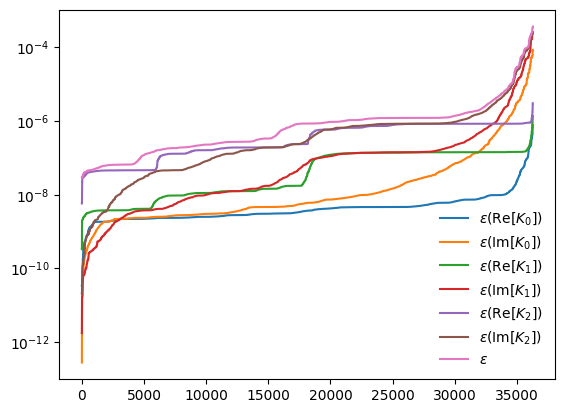

In [79]:
for key in [
       '$\epsilon$(Re[$K_0$])', '$\epsilon$(Im[$K_0$])', 
       '$\epsilon$(Re[$K_1$])', '$\epsilon$(Im[$K_1$])', 
       '$\epsilon$(Re[$K_2$])', '$\epsilon$(Im[$K_2$])', 
       '$\epsilon$']:
    
    plt.semilogy(sorted(abs(dg[key])), label=key)

plt.legend(frameon=False)
plt.show()    

# Discussion

Set `BREAKPOINTS` in the `KmatrixIII_jit_new` code above and re-run the tests. \
Here is a summary of the largest $\epsilon$ seen in each of the two tests:

| BREAKPOINTS | small test | large test |
| --- | --- | --- |
| 6 | 5.8% | 34% |
| 8 | 0.16% | 1.2% |
| 10 | 0.0029% | 0.036 % |

Wow, the accuracy improves dramatically as the number of integration breakpoints in increased! \
A summary of run times (i.e. user CPU time) for `BREAKPOINTS = 10`

| test | values varied | no. values | run time | run time per value |
| --- | --- | --- | --- | --- |
| small | $\boldsymbol{s}_j$, $\boldsymbol{r}_k$, $\omega$ | 108 | 767 ms | 7.1 ms |  
| large | $\boldsymbol{s}_j$, $\boldsymbol{r}_k$, $\omega$, $\epsilon_{\mathrm{s}}$, $\rho$, $\sigma$ | 36288 | 3 min 15s |  5.4 ms | 

Here are the two run-time-per-value computations:

In [80]:
767/108

7.101851851851852

In [81]:
(3 * 60 + 15) * 1000 / 36288

5.373677248677248

Above we estimated the run time per loop for `KmatrixIII_jit_new` to be $41.4 \mu$s.  \
The integration uses 10 breakpoints and 20 Newton-Cotes integration points per breakpoint. \
The expected run time per value in milliseconds is therefore

In [82]:
41.4e-6 * 10 * 20 * 1000

8.28

This number is in reasonable agreement with 7.1 and 5.4 ms estimates above. 

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-63.ipynb && open dissipation-theory--Study-63.html
    
:::